In [91]:
import pandas as pd
import nltk
import spacy
import locationtagger
import json
import os
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# essential entity models downloads
nltk.downloader.download('maxent_ne_chunker')
nltk.downloader.download('words')
nltk.downloader.download('treebank')
nltk.downloader.download('maxent_treebank_pos_tagger')
nltk.downloader.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package avera

True

In [3]:
df = pd.DataFrame([], columns=['book_id', 'hierarchy', 'language', 'nr_pages', 'word_count'])

path = 'data/transcripts/no_doubles/'

for filename in os.listdir(path):
    book = json.load(open(path + filename))
    data = {'book_id': filename.replace('.json', ''),
            'hierarchy': book['hierarchy'],
            'language': book['language'],
            'nr_pages': len(book['pages'])}
    
    
    # get the word count per book:
    data['word_count'] = 0
    for page in book['pages']:
        # if there are multiple transcriptions, we don't know which one to use
        if len(page) > 1:
            print('MULTIPLE TRANSCRIPTIONS FOUND: ' + filename)
            break
        else:
            p = page[0]
            for sentence in p:
                # remove all non-alphabetic characters
                data['word_count'] += len(re.sub('[^a-zA-Z ]+', '', sentence).split())

    data=pd.DataFrame(data, index=[0])
    df = pd.concat([df, data], axis=0, ignore_index=True)

In [8]:
meta_df = pd.read_csv('data/travel_df.csv', index_col =False)

# John Bell example exploration

In [55]:
# Getting all the texts by John Bell in a dataframe

john_bell_df = meta_df[meta_df['author'] == 'Bell, John']

path = 'data/transcripts/no_doubles/'

#dictionary containing the bookid and a list of text 

john_bell_texts = {}


for bookid in john_bell_df.book_id:
    filename = path + str(bookid) + '.json'

    book = json.load(open(filename))

    text = []

    for page in book['pages']:
        # if there are multiple transcriptions, we don't know which one to use
        if len(page) > 1:
            print('MULTIPLE TRANSCRIPTIONS FOUND: ' + filename)
            break
        else:
            if(page != ''):
                text += page

    john_bell_texts[bookid] = {'text': text}

In [63]:
# building a dictionary mapping page numbers to mentions of cities potentially to have a temporal mapping


for id in john_bell_texts: 
    
    for i in range(len(john_bell_texts[id]['text'])):
        # print(john_bell_texts[id])
        text = john_bell_texts[id]['text'][i]

        if(text != ''):
            # find locations per page

            place_entity = locationtagger.find_locations(text = text)

            #add cities to dictionary

            john_bell_texts[id]['cities'][i] = place_entity.cities


In [70]:
# not sure if lemmatization is necessary. To be discussed. (e.g. Roman stays Roman and not Rome)

from spacy.lemmatizer import Lemmatizer
#lemmatization 
nlp = spacy.load('en_core_web_sm')

for i in john_bell_texts[856820]['cities']: 
    cities = ' '.join(john_bell_texts[856820]['cities'][i])
    doc = nlp(cities)
    for token in doc: 
        print(token.lemma_)


Edinburgh
London
Bell
Royal
Strand
bell
Rome
Roman
Paris
Italy
Italy
Florence
England
Florence
Rome
Canova
German
Paris
Fontainebleau
Italy
Lyons
Paris
Macon
Fontainebleau
Saone
Lyons
Macon
Saone
Lyons
Savoy
Autun
Mont
Saone
Lyons
Roman
Mont
Saone
Lyons
Roman
Paris
Forum
Philip
Caracal
Lyons
Leglise
Saone
Lyons
Paris
Temple
Notre
Dame
Manchester
Lyons
Bridge
Ville
Lyons
Clovis
lyon
Lyons
Pierre
Pont
Saone
nine
Lyons
Roman
Le
Pont
Lyons
Morrow
Ed
Field
lyon
Lyons
Bron
Dauphin
Belair
lyon
Lyons
Roman
roman
Lyons
Leglise
German
Lyons
Leglise
four
English
Lyons
Roman
Eastern
Pont
Lyons
Paris
Savoy
Mont
Saone
lyon
Beauvoisin
Pont
Savoy
Duke
Savoy
Arco
Vale
Jean
Savoy
Arche
Bourg
Arco
Vale
Bourg
Arco
Vale
Alpine
Savoy
Val
Arco
Vale
Mont
Italy
Mont
Bush
Bush
Mont
Savoy
Les
Echelles
Mont
Hills
Mont
Piedmont
roman
Florence
Arco
Rivoli
Alpine
Piedmont
Doria
Turin
Rivoli
Doria
Rivoli
Lyons
Paris
Notre
Dame
Italy
Coleridge
Rivoli
Grenoble
Nice
Marseilles
Italy
Turin
Rivoli
Turin
Porta
turin
Ed
Tur

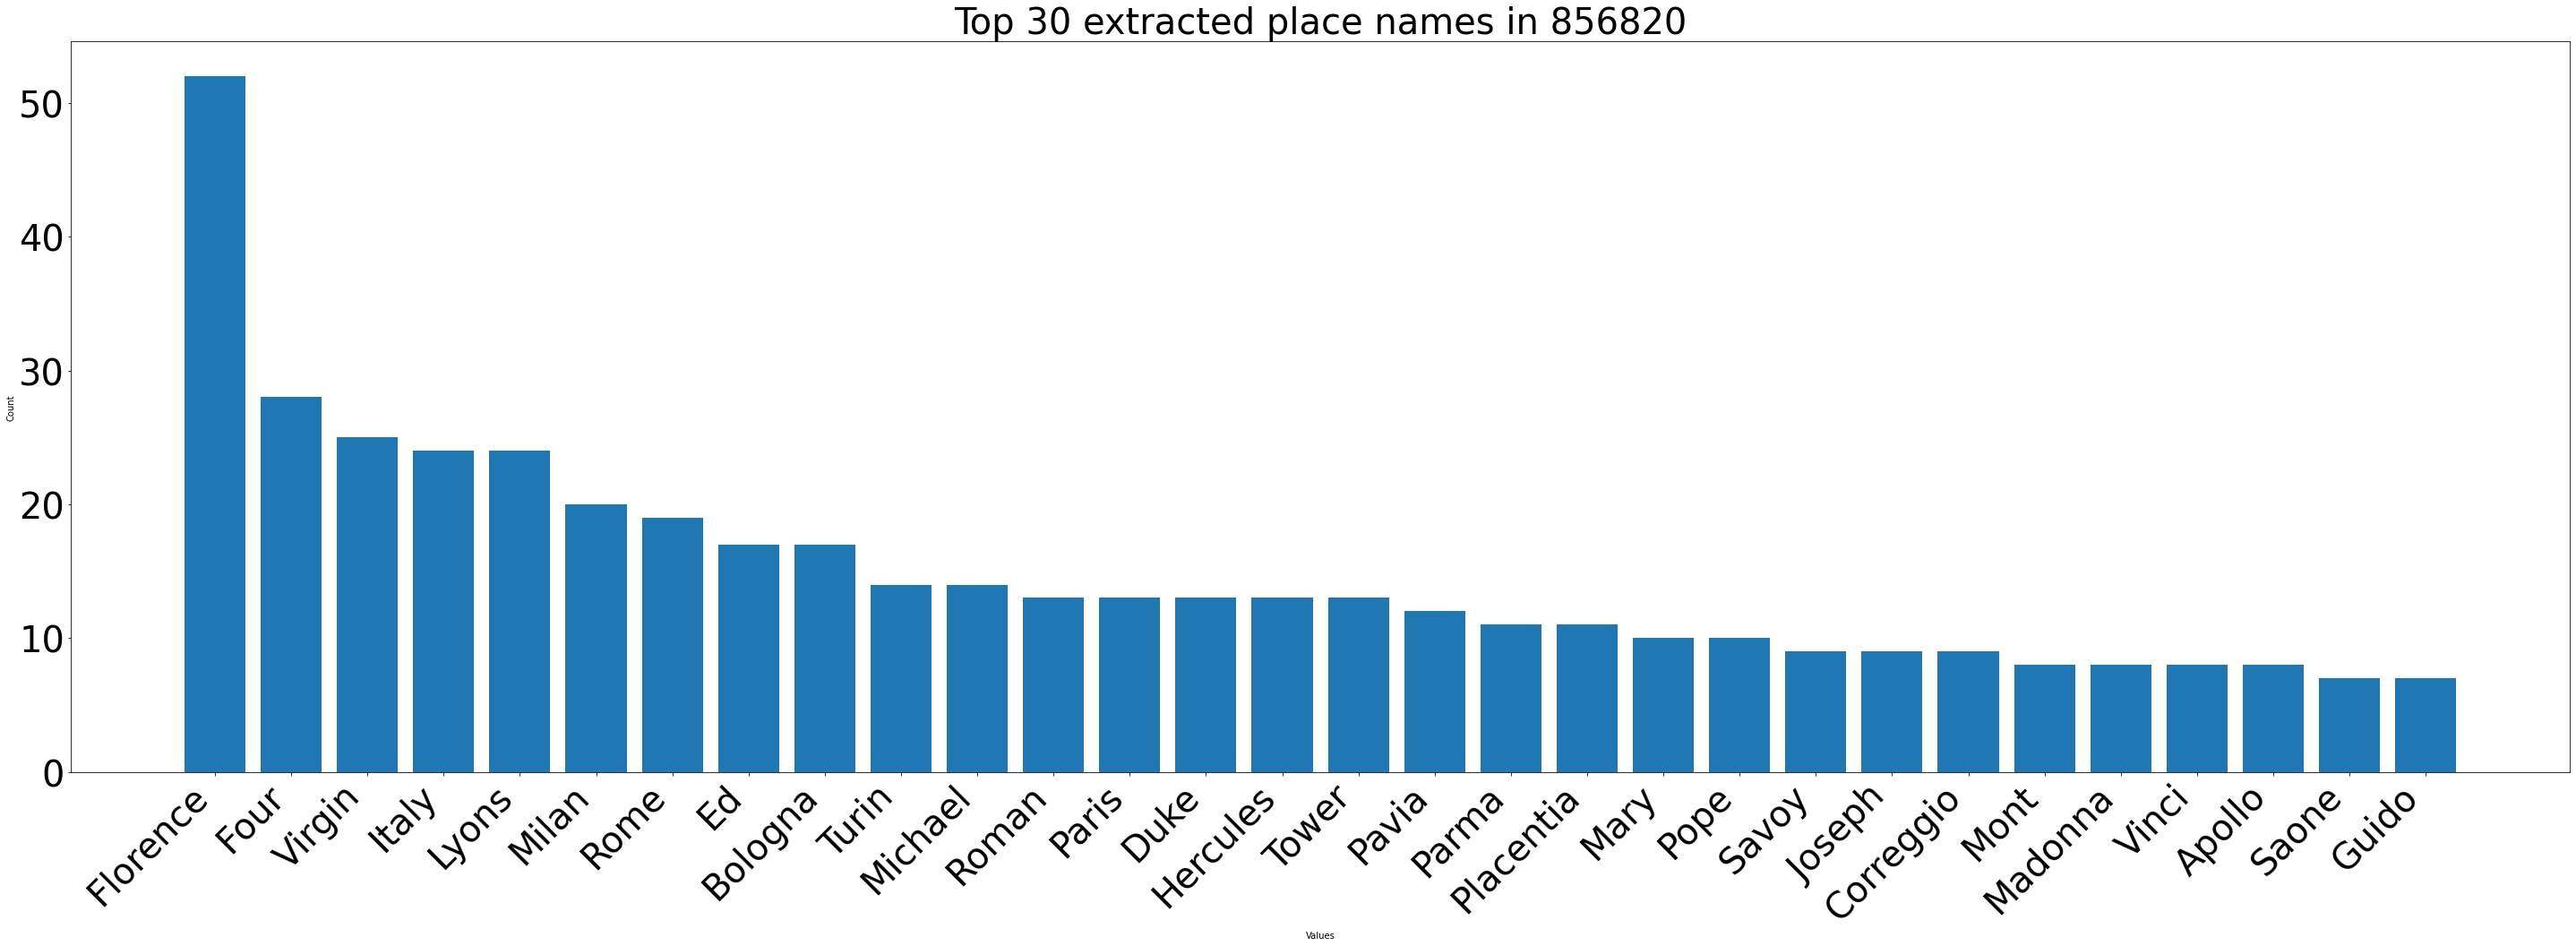

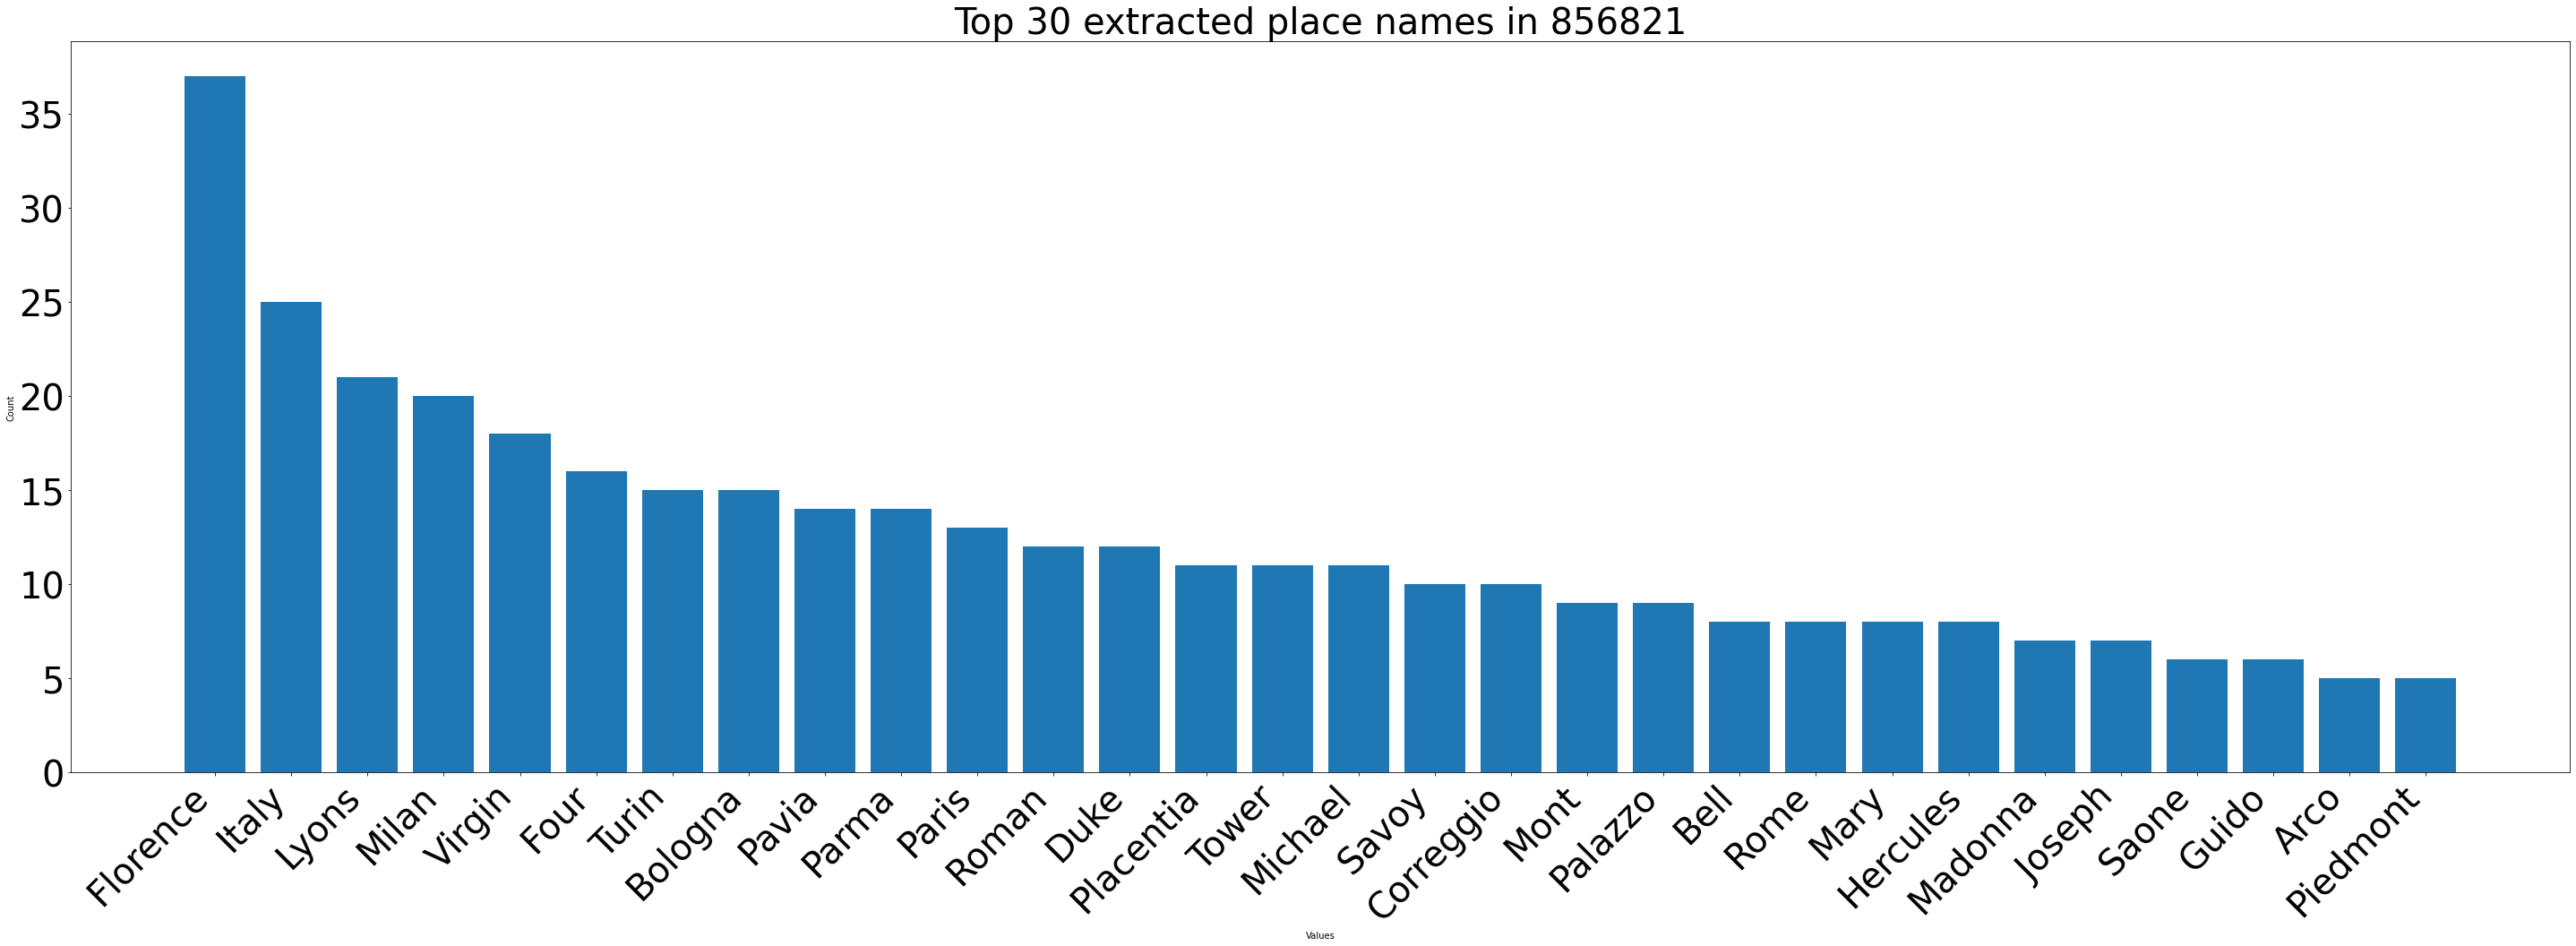

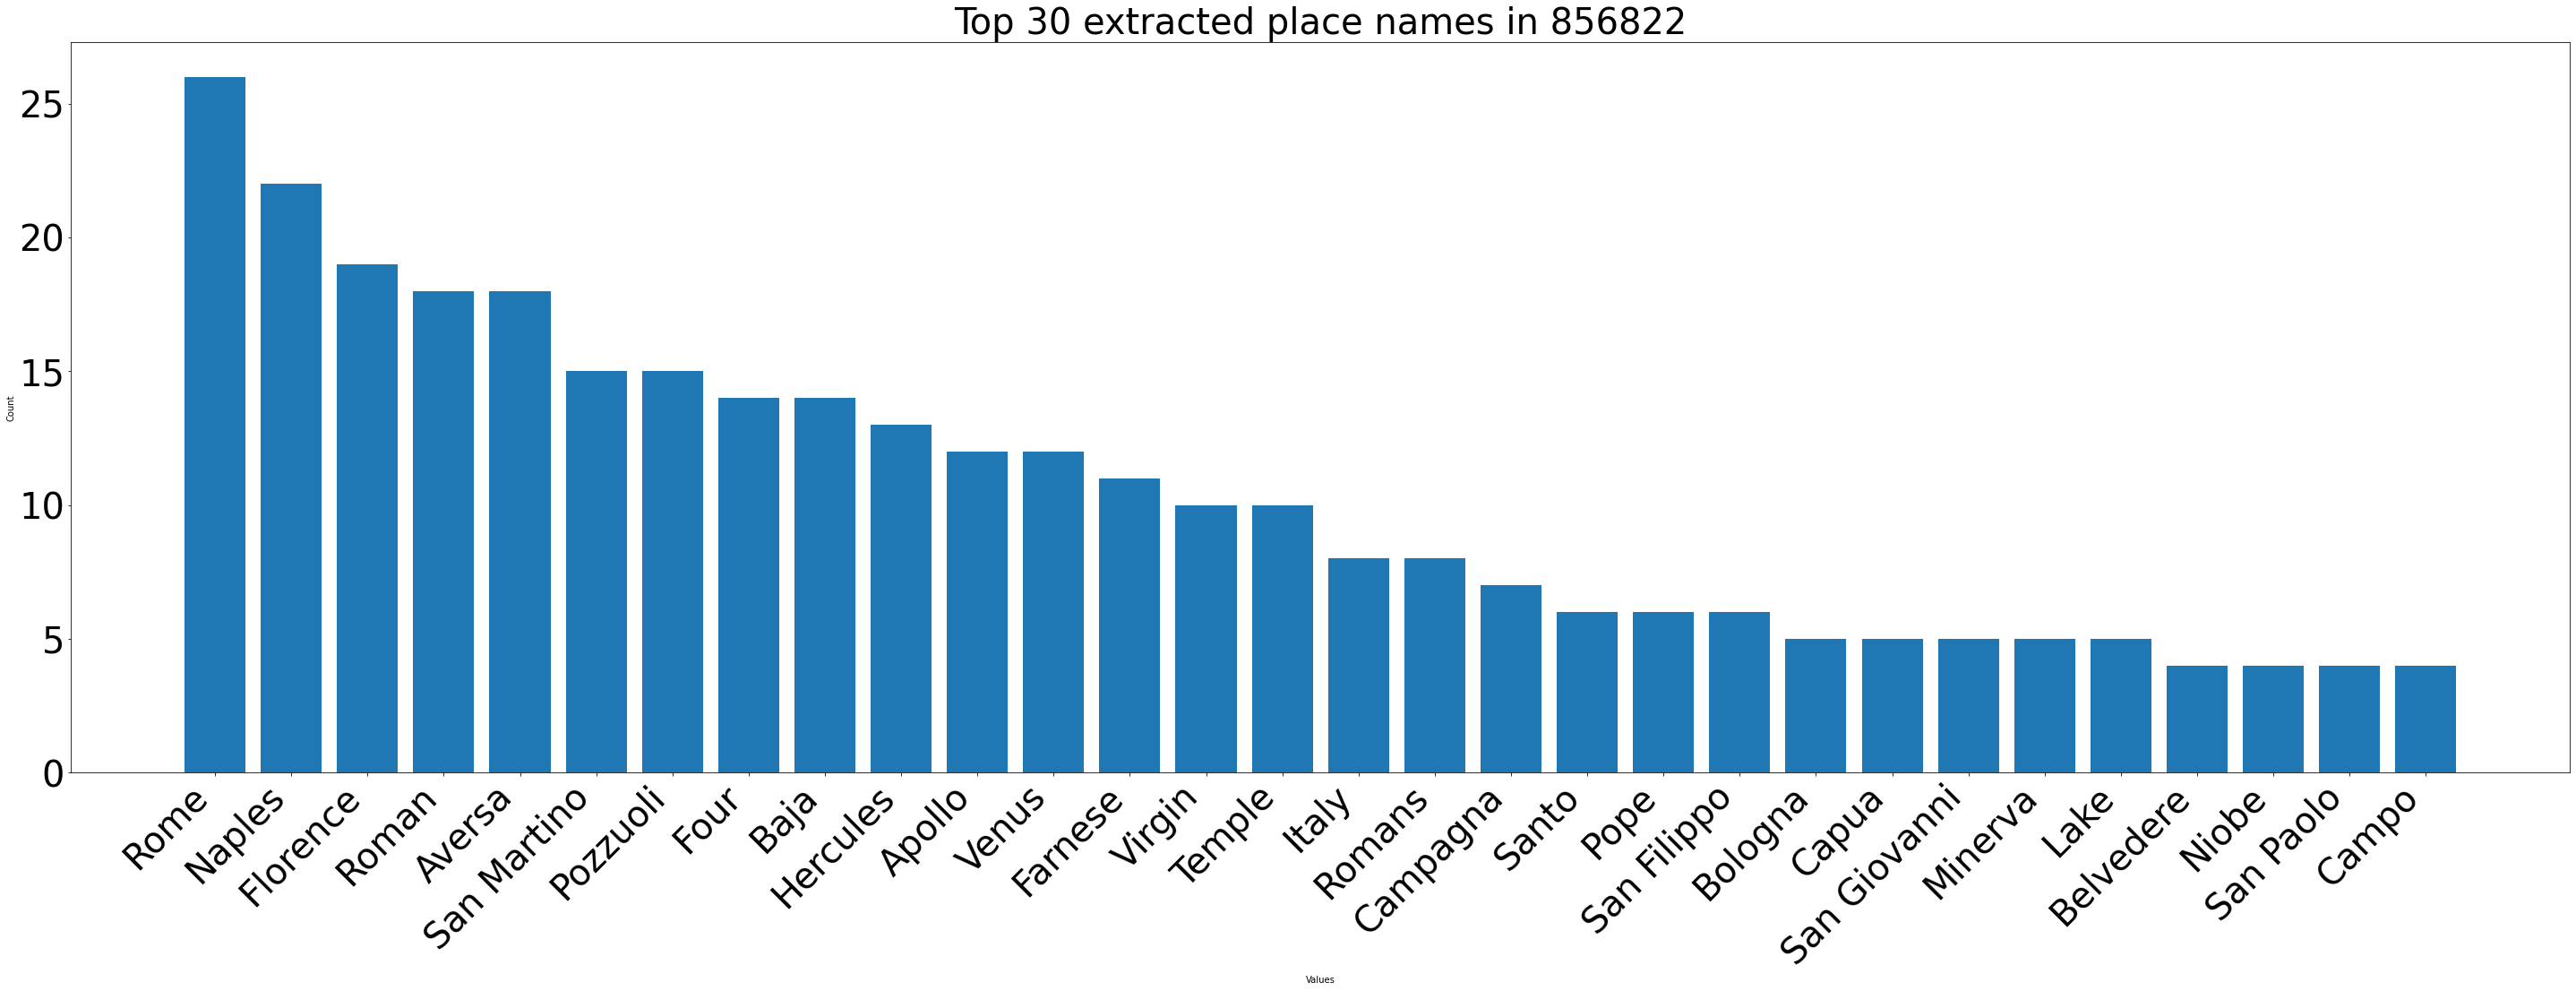

In [104]:
# total count per book (top 30)

for id in john_bell_texts: 

    cities = []

    for i in john_bell_texts[id]['cities']: 
        cities.extend(john_bell_texts[id]['cities'][i])
        
    counted_values = Counter(cities)

    # sort the counted values in descending order
    counted_values = dict(sorted(counted_values.items(), key=lambda item: item[1], reverse=True)[:30])  

    fig = plt.figure(figsize=(50, 15))
    
    plt.bar(counted_values.keys(), counted_values.values())
    # set x-label and y-label
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.title('Top 30 extracted place names in ' + str(id), fontsize=40)

    plt.xticks(rotation=45, ha='right', fontsize=40)
    plt.yticks(fontsize=40)
    plt.show()


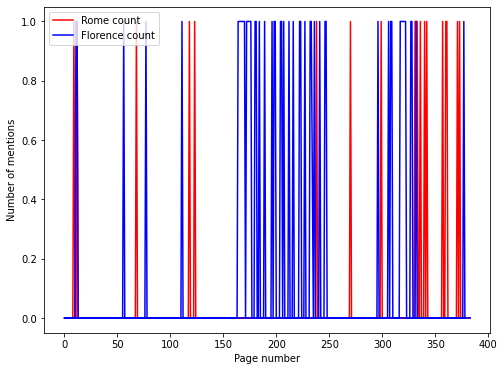

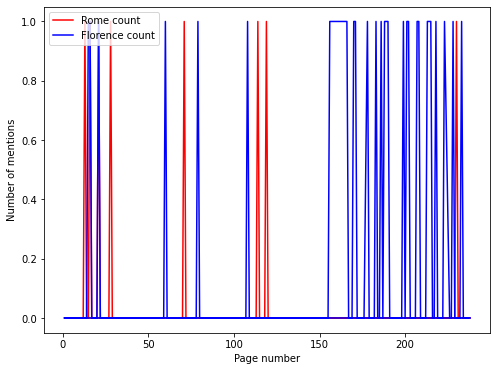

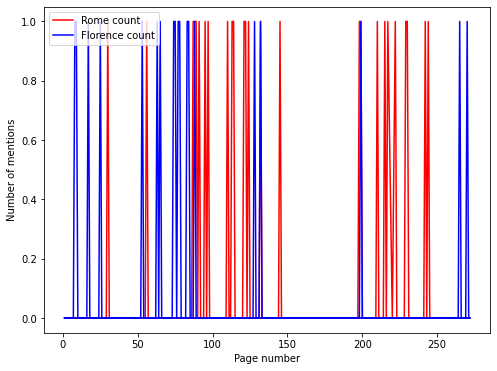

In [106]:
# Mapping occurence of Florence and Rome against each other


for id in john_bell_texts: 

    rome_by_page = []
    florence_by_page = []

    for page, cities in john_bell_texts[id]['cities'].items(): 
            rome_count = cities.count('Rome')
            florence_count = cities.count('Florence')

            rome_by_page.append((page, rome_count))
            florence_by_page.append((page, florence_count))
        
    fig = plt.figure(figsize=(8, 6))
    #plt.stackplot([x[0] for x in rome_by_page], [x[1] for x in rome_by_page], [x[1] for x in florence_by_page], labels=['Rome', 'Florence'])

    plt.plot([x[0] for x in rome_by_page], [x[1] for x in rome_by_page], 'r-', label='Rome count')
    plt.plot([x[0] for x in florence_by_page], [x[1] for x in florence_by_page], 'b-', label='Florence count')

    # set x-label and y-label
    plt.xlabel('Page number')
    plt.ylabel('Number of mentions')

    # add legend
    plt.legend(loc='upper left')

    plt.show()